## Import necessary packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import time

## Normalization + data augementation for training dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
    transforms.RandomHorizontalFlip(),  # Flip image horizontally
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

## Normalization for testing dataset

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

## Build-in CIFAR-10 dataset from PyTorch

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Just for visualization

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

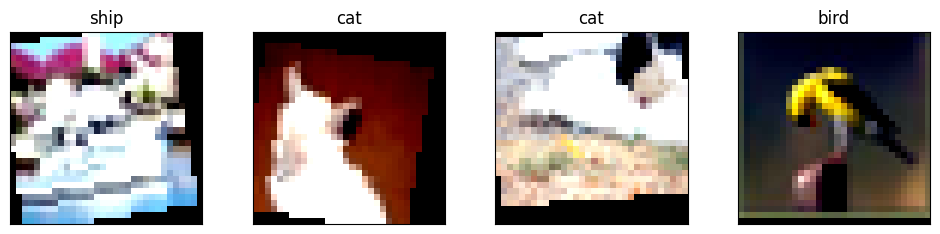

In [ ]:
def convert_image_format(image):
    image = image / 2 + 0.5
    image = image.numpy()
    return image.transpose(1,2,0)


data_iter = iter(trainloader)
images, labels = next(data_iter)


fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_image_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Data loader (Batch size set to 32)

In [ ]:
# Split trainset into training and validation sets
train_size = 45000
val_size = 5000
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders
trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
valloader = DataLoader(val_subset, batch_size=32, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Training

In [ ]:
def train(model, device, trainloader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    # Wrap the trainloader with tqdm for a progress bar
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}")

    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s")
    return epoch_loss, epoch_acc

def evaluate1(model, device, dataloader, criterion, split="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    print(f"{split}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

## Shallow CNN (3 layers)

In [ ]:
class ShallowCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ShallowCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Pooling after conv2: 16x16 -> 8x8

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Pooling after conv3: 8x8 -> 4x4

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.1)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Conv Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Conv Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Conv Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [ ]:
# Train & Eval ShallowCNN
def train_shallow_cnn():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ShallowCNN(num_classes=10).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 75

    best_val_acc = 0
    for epoch in range(1, num_epochs+1):
        # Training
        train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch)

        # Validation
        val_loss, val_acc = evaluate1(model, device, valloader, criterion, split="Validation")

        # Save model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'shallow_cnn_cifar10_best.pth')
            print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")

        print()

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    # Test
    model = ShallowCNN(num_classes=10).to(device)
    model.load_state_dict(torch.load('shallow_cnn_cifar10_best.pth'))
    test_loss, test_acc = evaluate1(model, device, testloader, criterion, split="Test")
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

train_shallow_cnn()

## DenseNet CNN: https://arxiv.org/pdf/1608.06993

In [ ]:
class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate,
                               kernel_size=1, stride=1, bias=False)
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = self.conv1(self.relu1(self.norm1(x)))
        new_features = self.conv2(self.relu2(self.norm2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        # Concatenate input with new features
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            layers.append(layer)
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class _Transition(nn.Module):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features,
                              kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.norm(x)))
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(16, 16, 16),
                 num_init_features=24, bn_size=4, drop_rate=0.1, num_classes=10):
        """
        Parameters:
          growth_rate (int): How many filters to add each layer (k in DenseNet paper).
          block_config (tuple of ints): How many layers in each dense block.
          num_init_features (int): The number of filters to learn in the first convolution layer.
          bn_size (int): Multiplicative factor for bottleneck layers.
          drop_rate (float): Dropout rate after each dense layer.
          num_classes (int): Number of classes for classification.
        """
        super(DenseNet, self).__init__()

        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
        )

        # Each denseblock
        num_features = num_init_features
        self.denseblocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)

            self.denseblocks.append(block)
            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)

                self.transitions.append(trans)
                num_features = num_features // 2

        # Final batch norm
        self.norm_final = nn.BatchNorm2d(num_features)
        # Linear classifier
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.features(x)
        for i in range(len(self.denseblocks)):
            out = self.denseblocks[i](out)
            if i < len(self.transitions):
                out = self.transitions[i](out)
        out = self.norm_final(out)
        out = F.relu(out, inplace=True)
        # Global average pooling
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [ ]:
model = DenseNet(growth_rate=12, block_config=(16,16,16), num_init_features=24,
                     bn_size=4, drop_rate=0.1, num_classes=10)
# print model params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 769210


In [ ]:
# Train & Eval DenseNet
def train_densenet():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = DenseNet(growth_rate=12, block_config=(16,16,16), num_init_features=24,
                     bn_size=4, drop_rate=0.1, num_classes=10).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    num_epochs = 50

    best_val_acc = 0
    for epoch in range(1, num_epochs+1):
        # Training
        train_loss, train_acc = train(model, device, trainloader, optimizer, criterion, epoch)

        # Validation
        val_loss, val_acc = evaluate1(model, device, valloader, criterion, split="Validation")

        # Save model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'densenet_cifar10_best.pth')
            print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")

        print()

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    # Test
    test_loss, test_acc = evaluate1(model, device, testloader, criterion, split="Test")

train_densenet()

Epoch 1: 100%|██████████| 1407/1407 [02:20<00:00, 10.04it/s, loss=0.906]


Epoch 1: Train Loss: 1.4753, Train Accuracy: 45.74%, Time: 140.16s
Validation: Loss: 1.1302, Accuracy: 58.90%
Saved best model with validation accuracy: 58.90%



Epoch 2: 100%|██████████| 1407/1407 [02:15<00:00, 10.37it/s, loss=0.935]


Epoch 2: Train Loss: 1.0700, Train Accuracy: 61.69%, Time: 135.69s
Validation: Loss: 0.9971, Accuracy: 64.20%
Saved best model with validation accuracy: 64.20%



Epoch 3: 100%|██████████| 1407/1407 [02:15<00:00, 10.39it/s, loss=1.7]


Epoch 3: Train Loss: 0.9029, Train Accuracy: 68.19%, Time: 135.42s
Validation: Loss: 0.9135, Accuracy: 67.44%
Saved best model with validation accuracy: 67.44%



Epoch 4: 100%|██████████| 1407/1407 [02:16<00:00, 10.34it/s, loss=0.972]


Epoch 4: Train Loss: 0.7882, Train Accuracy: 72.16%, Time: 136.03s
Validation: Loss: 0.8266, Accuracy: 70.90%
Saved best model with validation accuracy: 70.90%



Epoch 5: 100%|██████████| 1407/1407 [02:15<00:00, 10.36it/s, loss=0.918]


Epoch 5: Train Loss: 0.6954, Train Accuracy: 75.79%, Time: 135.77s
Validation: Loss: 0.6696, Accuracy: 76.56%
Saved best model with validation accuracy: 76.56%



Epoch 6: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.321]


Epoch 6: Train Loss: 0.6395, Train Accuracy: 77.78%, Time: 135.27s
Validation: Loss: 0.6185, Accuracy: 78.14%
Saved best model with validation accuracy: 78.14%



Epoch 7: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.896]


Epoch 7: Train Loss: 0.5970, Train Accuracy: 79.44%, Time: 135.33s
Validation: Loss: 0.5462, Accuracy: 80.52%
Saved best model with validation accuracy: 80.52%



Epoch 8: 100%|██████████| 1407/1407 [02:14<00:00, 10.42it/s, loss=0.182]


Epoch 8: Train Loss: 0.5544, Train Accuracy: 80.73%, Time: 134.99s
Validation: Loss: 0.5384, Accuracy: 81.26%
Saved best model with validation accuracy: 81.26%



Epoch 9: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=0.291]


Epoch 9: Train Loss: 0.5227, Train Accuracy: 81.96%, Time: 134.86s
Validation: Loss: 0.5459, Accuracy: 80.92%



Epoch 10: 100%|██████████| 1407/1407 [02:15<00:00, 10.38it/s, loss=1.22]


Epoch 10: Train Loss: 0.4892, Train Accuracy: 83.21%, Time: 135.57s
Validation: Loss: 0.5363, Accuracy: 81.90%
Saved best model with validation accuracy: 81.90%



Epoch 11: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=1.28]


Epoch 11: Train Loss: 0.4666, Train Accuracy: 83.68%, Time: 135.31s
Validation: Loss: 0.4700, Accuracy: 83.70%
Saved best model with validation accuracy: 83.70%



Epoch 12: 100%|██████████| 1407/1407 [02:14<00:00, 10.44it/s, loss=0.525]


Epoch 12: Train Loss: 0.4466, Train Accuracy: 84.44%, Time: 134.83s
Validation: Loss: 0.5051, Accuracy: 82.92%



Epoch 13: 100%|██████████| 1407/1407 [02:14<00:00, 10.42it/s, loss=0.541]


Epoch 13: Train Loss: 0.4284, Train Accuracy: 85.14%, Time: 135.00s
Validation: Loss: 0.4370, Accuracy: 85.42%
Saved best model with validation accuracy: 85.42%



Epoch 14: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.693]


Epoch 14: Train Loss: 0.4106, Train Accuracy: 85.64%, Time: 135.27s
Validation: Loss: 0.4813, Accuracy: 83.78%



Epoch 15: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=1.06]


Epoch 15: Train Loss: 0.3960, Train Accuracy: 86.26%, Time: 135.06s
Validation: Loss: 0.4539, Accuracy: 84.52%



Epoch 16: 100%|██████████| 1407/1407 [02:15<00:00, 10.38it/s, loss=0.506]


Epoch 16: Train Loss: 0.3788, Train Accuracy: 86.77%, Time: 135.55s
Validation: Loss: 0.4081, Accuracy: 85.80%
Saved best model with validation accuracy: 85.80%



Epoch 17: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=0.106]


Epoch 17: Train Loss: 0.3620, Train Accuracy: 87.32%, Time: 134.90s
Validation: Loss: 0.4049, Accuracy: 86.58%
Saved best model with validation accuracy: 86.58%



Epoch 18: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=0.437]


Epoch 18: Train Loss: 0.3494, Train Accuracy: 87.86%, Time: 135.03s
Validation: Loss: 0.3751, Accuracy: 87.38%
Saved best model with validation accuracy: 87.38%



Epoch 19: 100%|██████████| 1407/1407 [02:14<00:00, 10.42it/s, loss=0.335]


Epoch 19: Train Loss: 0.3432, Train Accuracy: 87.98%, Time: 135.00s
Validation: Loss: 0.4012, Accuracy: 86.70%



Epoch 20: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=0.205]


Epoch 20: Train Loss: 0.3302, Train Accuracy: 88.66%, Time: 134.96s
Validation: Loss: 0.3859, Accuracy: 86.90%



Epoch 21: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=1.14]


Epoch 21: Train Loss: 0.3168, Train Accuracy: 88.86%, Time: 135.01s
Validation: Loss: 0.4128, Accuracy: 86.74%



Epoch 22: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.333]


Epoch 22: Train Loss: 0.3077, Train Accuracy: 89.24%, Time: 135.28s
Validation: Loss: 0.3529, Accuracy: 88.34%
Saved best model with validation accuracy: 88.34%



Epoch 23: 100%|██████████| 1407/1407 [02:15<00:00, 10.39it/s, loss=0.616]


Epoch 23: Train Loss: 0.2997, Train Accuracy: 89.54%, Time: 135.36s
Validation: Loss: 0.3837, Accuracy: 87.56%



Epoch 24: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.34]


Epoch 24: Train Loss: 0.2839, Train Accuracy: 90.10%, Time: 135.30s
Validation: Loss: 0.3739, Accuracy: 87.26%



Epoch 25: 100%|██████████| 1407/1407 [02:15<00:00, 10.41it/s, loss=0.0664]


Epoch 25: Train Loss: 0.2807, Train Accuracy: 90.16%, Time: 135.14s
Validation: Loss: 0.3524, Accuracy: 88.14%



Epoch 26: 100%|██████████| 1407/1407 [02:15<00:00, 10.39it/s, loss=0.164]


Epoch 26: Train Loss: 0.2730, Train Accuracy: 90.48%, Time: 135.41s
Validation: Loss: 0.3780, Accuracy: 87.28%



Epoch 27: 100%|██████████| 1407/1407 [02:15<00:00, 10.39it/s, loss=0.281]


Epoch 27: Train Loss: 0.2639, Train Accuracy: 90.64%, Time: 135.36s
Validation: Loss: 0.3751, Accuracy: 88.08%



Epoch 28: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.294]


Epoch 28: Train Loss: 0.2566, Train Accuracy: 90.98%, Time: 135.29s
Validation: Loss: 0.3580, Accuracy: 87.78%



Epoch 29: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.483]


Epoch 29: Train Loss: 0.2544, Train Accuracy: 91.09%, Time: 135.23s
Validation: Loss: 0.3626, Accuracy: 87.90%



Epoch 30: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=0.0329]


Epoch 30: Train Loss: 0.2454, Train Accuracy: 91.26%, Time: 135.01s
Validation: Loss: 0.3368, Accuracy: 88.74%
Saved best model with validation accuracy: 88.74%



Epoch 31: 100%|██████████| 1407/1407 [02:15<00:00, 10.38it/s, loss=1.22]


Epoch 31: Train Loss: 0.2366, Train Accuracy: 91.62%, Time: 135.57s
Validation: Loss: 0.3423, Accuracy: 89.48%
Saved best model with validation accuracy: 89.48%



Epoch 32: 100%|██████████| 1407/1407 [02:15<00:00, 10.37it/s, loss=0.0473]


Epoch 32: Train Loss: 0.2326, Train Accuracy: 91.75%, Time: 135.62s
Validation: Loss: 0.3615, Accuracy: 88.42%



Epoch 33: 100%|██████████| 1407/1407 [02:15<00:00, 10.39it/s, loss=0.5]


Epoch 33: Train Loss: 0.2320, Train Accuracy: 91.91%, Time: 135.40s
Validation: Loss: 0.3322, Accuracy: 89.36%



Epoch 34: 100%|██████████| 1407/1407 [02:15<00:00, 10.41it/s, loss=0.0973]


Epoch 34: Train Loss: 0.2204, Train Accuracy: 92.42%, Time: 135.20s
Validation: Loss: 0.3599, Accuracy: 88.92%



Epoch 35: 100%|██████████| 1407/1407 [02:15<00:00, 10.38it/s, loss=0.307]


Epoch 35: Train Loss: 0.2192, Train Accuracy: 92.21%, Time: 135.51s
Validation: Loss: 0.3412, Accuracy: 88.86%



Epoch 36: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=1.44]


Epoch 36: Train Loss: 0.2104, Train Accuracy: 92.58%, Time: 135.36s
Validation: Loss: 0.3379, Accuracy: 89.32%



Epoch 37: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.0802]


Epoch 37: Train Loss: 0.2052, Train Accuracy: 92.75%, Time: 135.26s
Validation: Loss: 0.3397, Accuracy: 89.12%



Epoch 38: 100%|██████████| 1407/1407 [02:14<00:00, 10.42it/s, loss=0.0649]


Epoch 38: Train Loss: 0.2019, Train Accuracy: 92.95%, Time: 134.98s
Validation: Loss: 0.3294, Accuracy: 89.78%
Saved best model with validation accuracy: 89.78%



Epoch 39: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=0.233]


Epoch 39: Train Loss: 0.2002, Train Accuracy: 93.07%, Time: 135.06s
Validation: Loss: 0.3374, Accuracy: 89.06%



Epoch 40: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=1.63]


Epoch 40: Train Loss: 0.1935, Train Accuracy: 93.03%, Time: 134.91s
Validation: Loss: 0.3355, Accuracy: 89.28%



Epoch 41: 100%|██████████| 1407/1407 [02:15<00:00, 10.41it/s, loss=0.787]


Epoch 41: Train Loss: 0.1892, Train Accuracy: 93.27%, Time: 135.20s
Validation: Loss: 0.3533, Accuracy: 89.40%



Epoch 42: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=0.0284]


Epoch 42: Train Loss: 0.1874, Train Accuracy: 93.41%, Time: 134.90s
Validation: Loss: 0.3240, Accuracy: 90.12%
Saved best model with validation accuracy: 90.12%



Epoch 43: 100%|██████████| 1407/1407 [02:15<00:00, 10.41it/s, loss=0.995]


Epoch 43: Train Loss: 0.1847, Train Accuracy: 93.53%, Time: 135.17s
Validation: Loss: 0.3434, Accuracy: 89.16%



Epoch 44: 100%|██████████| 1407/1407 [02:14<00:00, 10.44it/s, loss=0.0955]


Epoch 44: Train Loss: 0.1765, Train Accuracy: 93.76%, Time: 134.82s
Validation: Loss: 0.3353, Accuracy: 90.06%



Epoch 45: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=0.0268]


Epoch 45: Train Loss: 0.1761, Train Accuracy: 93.78%, Time: 134.95s
Validation: Loss: 0.3295, Accuracy: 90.04%



Epoch 46: 100%|██████████| 1407/1407 [02:15<00:00, 10.41it/s, loss=0.0885]


Epoch 46: Train Loss: 0.1773, Train Accuracy: 93.77%, Time: 135.13s
Validation: Loss: 0.3344, Accuracy: 90.26%
Saved best model with validation accuracy: 90.26%



Epoch 47: 100%|██████████| 1407/1407 [02:14<00:00, 10.43it/s, loss=1.48]


Epoch 47: Train Loss: 0.1649, Train Accuracy: 94.15%, Time: 134.86s
Validation: Loss: 0.3346, Accuracy: 89.96%



Epoch 48: 100%|██████████| 1407/1407 [02:15<00:00, 10.38it/s, loss=0.125]


Epoch 48: Train Loss: 0.1660, Train Accuracy: 94.12%, Time: 135.51s
Validation: Loss: 0.3437, Accuracy: 89.68%



Epoch 49: 100%|██████████| 1407/1407 [02:15<00:00, 10.42it/s, loss=0.000945]


Epoch 49: Train Loss: 0.1571, Train Accuracy: 94.34%, Time: 135.07s
Validation: Loss: 0.3310, Accuracy: 90.50%
Saved best model with validation accuracy: 90.50%



Epoch 50: 100%|██████████| 1407/1407 [02:15<00:00, 10.40it/s, loss=0.11]


Epoch 50: Train Loss: 0.1601, Train Accuracy: 94.40%, Time: 135.25s
Validation: Loss: 0.3421, Accuracy: 89.90%

Best Validation Accuracy: 90.50%
Test: Loss: 0.3692, Accuracy: 90.05%


## ViT Dino-v2 Small

In [ ]:
class DINOv2SmallCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(DINOv2SmallCIFAR10, self).__init__()
        print("Loading DINOv2-Small model from PyTorch Hub...")
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.embed_dim = 384
        self.classifier = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        with torch.no_grad():
            features = self.model(x)
        logits = self.classifier(features)

        return logits

# Evaluation function
def evaluate(model, data_loader, criterion, device, split="Test"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    eval_loss = running_loss / total
    eval_acc = 100. * correct / total

    print(f"{split}: Loss: {eval_loss:.4f}, Accuracy: {eval_acc:.2f}%")
    return eval_loss, eval_acc

# Testing

## Shallow CNN

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ShallowCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('shallow_cnn_cifar10_best.pth'))
test_loss, test_acc = evaluate1(model, device, testloader, criterion, split="Test")

Test: Loss: 0.5299, Accuracy: 83.46%


## DenseNet

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DenseNet(growth_rate=12, block_config=(16,16,16), num_init_features=24,
                     bn_size=4, drop_rate=0.1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('densenet_cifar10_best.pth'))
test_loss, test_acc = evaluate1(model, device, testloader, criterion, split="Test")

Test: Loss: 0.3349, Accuracy: 91.22%


## ViT Dino-v2 Small

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DINOv2SmallCIFAR10(num_classes=10).to(device)
checkpoint = torch.load('dinov2_best.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
test_loss, test_acc = evaluate(model, testloader, criterion, device, split="Test")

Loading DINOv2-Small model from PyTorch Hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Test: Loss: 0.1256, Accuracy: 95.95%
